# **Orbweaver 3.0**

### The latest iteration of an all-in-one tool for analysing our orbit.

Orbweaver helps you select a Sun Synchronous Orbit for your satellite, and simulate it to determine when you can make imaging passes over a given location on Earth. It also provides information about the total sunlight hours the satellite receives.

### Changelog

### 3.0 (Dec 24 to 25, 2020)

*   Initial Release
*   Setting, propagating orbit
*   Analysis of Imaging Passes, Solar Illumination, Spacecraft Ground Track



In [ ]:
#@title ## Stage 1: Install Dependencies { display-mode: "form" }
#@markdown Click the run button on this cell to install dependencies. It will take up to one minute.

%%capture
!pip install poliastro
!pip install mpld3

!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely;

In [ ]:
!apt-get -qq install python-cartopy python3-cartopy;

In [ ]:
#@markdown Imports (run this cell)

import numpy as np

import pandas as pd
%load_ext google.colab.data_table

from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, GCRS, ITRS, AltAz, CartesianRepresentation, CartesianDifferential, get_body, solar_system_ephemeris
from astropy import coordinates as coord

from poliastro.bodies import Earth, Sun
from poliastro.twobody import Orbit
from poliastro.core.perturbations import J2_perturbation, shadow_function
from poliastro.twobody.propagation import cowell, propagate
from poliastro.ephem import Ephem
solar_system_ephemeris.set("jpl")

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import mpld3
from mpld3 import plugins

from ipywidgets import interact
import ipywidgets as widgets

from scipy.interpolate import UnivariateSpline
from scipy.spatial.transform import Rotation

print("Imports complete")



Imports complete


## Stage 2: Define the Orbit
We use Poliastro to help us compute the parameters of a Sun Synchronous Orbit, based on our desired LTAN.

**SMA**: Semi-Major Axis (km)

**LTAN**: Local Time at Ascending Node -- exactly 12 hours difference from LTDN. Input as a number of hours from 0 to 24.

**Eccentricity**: Eccentricity of orbit (0 to 1)

**Argument of Perigee**: Angle from 0 to 360 degrees

**Total Anomaly**: How far you are along the orbit, from 0 to 360 degrees

**Epoch**: When these parameters hold true. Input date using the form. Input time format at "HH:MM" (24 hour time, UTC)

*NOTE: Output format will show time as (TDB); Do not worry, as this is just used as an intermediate step. The real UTC time is kept.*

In [ ]:
#@title Orbit Parameters
SMA =  6878#@param {type:"number"}
LTAN =  22.5#@param {type:"number"}
Eccentricity = 0 #@param {type:"number"}
argument_of_perigee = 0 #@param {type:"number"}
total_anomaly = 0 #@param {type:"number"}
epoch_date = "2024-06-01" #@param {type:"date"}
epoch_time = "00:00" #@param {type:"string"}

# convert parameters to dimensionful values
a = SMA * u.km
e = Eccentricity * u.one
argpe = argument_of_perigee * u.deg
ta = total_anomaly * u.deg
LTAN = LTAN*u.hourangle

# Store time as UTC
epoch = Time(f"{epoch_date} {epoch_time}", format='iso', scale="utc")

# Define orbital parameters, along with units
orb = Orbit.heliosynchronous(attractor=Earth, a=a, ecc=e, ltan=LTAN, argp=argpe, nu=ta, epoch=epoch)

print(orb.classical())

orb
# Time in orbit is now stored as TDB

(<Quantity 6878. km>, <Quantity 0.>, <Quantity 97.40096011 deg>, <Angle 587.05566155 deg>, <Quantity 0. deg>, <Quantity 0. deg>)


6878 x 6878 km x 97.4 deg (GCRS) orbit around Earth (♁) at epoch 2024-06-01 00:01:09.185 (TDB)

In [ ]:
orb.inc*180/np.pi

<Quantity 97.40096011 rad>

## Stage 3: Propagate the Orbit

We use Poliastro's propagator module to step forward in time, applying numerical integration using Cowell's method to simulate the satellite orbiting the Earth.

The result of a set of AstroPy Sky Coordinates in the GCRS frame, which we can use to figure out where the satellite is wrt the Earth.

### *This step takes some time.*

**num_days**: Number of days to propagate forwards to.

**num_steps**: Number of integration steps used.


**TODO Implement atmospheric effects**

In [ ]:
#@title Cowell Propagation Parameters

#@markdown We use Cowell's method to numerically integrate the spacecraft's postion forward, accounting for J2 pertubations, which are responsible for maintaing Sun synchronicity.

num_days =  2#@param {type:"number"}
num_steps =  10000#@param {type:"integer"}

tof = (num_days * u.d).to(u.s) # time in seconds

times = np.linspace(0, tof, num_steps)

# Obtain propagated positions and velocities using Cowell's method, applying J2 perturbations
propagated_positions = propagate(orb, times, method=cowell, ad=J2_perturbation, J2=Earth.J2.value, R=Earth.R.to(u.km).value)
propagated_velocities = propagated_positions.differentials["s"]

# Obtain jd dates along the propagation steps to feed into astropy as position data
# We work in TDB for propagation since the orbit data is stored in TDB
observation_times = Time(np.linspace(0, num_days, num_steps) + orb.epoch.jd, format="jd", scale="tdb")
observation_times.format = "iso"

# plug everything into AstroPy; positions, velocities, times
sky_coordinates = SkyCoord(frame=GCRS(obstime=observation_times), 
                           x=propagated_positions.x,
                           y=propagated_positions.y,
                           z=propagated_positions.z,
                           v_x=propagated_velocities.d_x,
                           v_y=propagated_velocities.d_y,
                           v_z=propagated_velocities.d_z,
                           representation_type = "cartesian",
                           differential_type = "cartesian")
print(f"Cowell Propagation successful to {sky_coordinates[-1].obstime.utc} UTC")


Cowell Propagation successful to 2024-06-03 00:00:00.000 UTC


In [ ]:
#@markdown We can check to see what has happened to our orbit after propagating it for that time
new_orbit = Orbit.from_coords(Earth, sky_coordinates[-1])
new_orbit

6846 x 6872 km x 97.4 deg (GCRS) orbit around Earth (♁) at epoch 2024-06-02 00:01:09.185 (TDB)

In [ ]:
#@title ###Visualizing the Orbits
#@markdown We can use Poliastro's Orbitplotter to get an idea of how our spacecraft has moved.

#@markdown Note again that all times are shown in TDB instead of UTC.

from poliastro.plotting import OrbitPlotter2D

op = OrbitPlotter2D()

op.plot(orb)
op.plot(new_orbit)

In [ ]:
#@title Mean Motion Propagation

#@markdown We also have the option of using a much faster but inaccurate method (Mean Motion) for validation. This pretends that the only force acting on the spacecraft is gravity, which does not take into account J2, Drag etc.

#@markdown This uses the same timestep and duration as the Cowell section above, but please do not use this data for pass estimation.

tof = (num_days * u.d).to(u.s) # time in seconds

times = np.linspace(0, tof, num_steps)

mm_positions = propagate(orb, times)
mm_velocities = propagated_positions.differentials["s"]

# plug everything into AstroPy; positions, velocities, times
mm_coordinates = SkyCoord(frame=GCRS(obstime=observation_times), 
                           x=mm_positions.x,
                           y=mm_positions.y,
                           z=mm_positions.z,
                           v_x=mm_velocities.d_x,
                           v_y=mm_velocities.d_y,
                           v_z=mm_velocities.d_z,
                           representation_type = "cartesian",
                           differential_type = "cartesian")
print(f"Mean Motion calculation successful to {mm_coordinates[-1].obstime.utc} UTC")


Mean Motion calculation successful to 2024-06-02 00:00:00.000 UTC


## Stage 4: Analyze the Orbit

We can finally start figuring out the behaviour of the orbit as it passes over a given location on Earth.

We first create an altitude-azimuth coordinate system in which we can figure out a spacecraft's position over time in the new coordinate frame.

In [ ]:
#@title Enter a Location on Earth for Analysis

#@markdown **Latitude**: from -90 to 90 degrees

#@markdown **Longitude**: from -180 to 180 degrees

#@markdown **Elevation**: in metres (Search this one up on Google)

Latitude = 43.651070 #@param {type:"number"}
Longitude = -79.3832 #@param {type:"number"}
Elevation = 76 #@param {type:"number"}

loc = EarthLocation.from_geodetic(Longitude*u.deg,Latitude*u.deg, Elevation*u.m)
# Earth location

aa_frame = AltAz(obstime=observation_times, location=loc) 
# Coordinate system: Az/Alt from a given location on Earth

print(f"Coordinate Frame Established at {Longitude}° Longitude, {Latitude}° Latitude")

Coordinate Frame Established at -79.3832° Longitude, 43.65107° Latitude


In [ ]:
#@title Transform the spacecraft's position into the Alt-Az frame

#@markdown This step also takes some time.
aa_coords = sky_coordinates.transform_to(aa_frame)

mpljd_times = sky_coordinates.obstime.mjd - 40587

print("Spacecraft positions transformed into Alt-Az frame.")

Spacecraft positions transformed into Alt-Az frame.


In [ ]:
#@markdown We can plot the Altitude of the Spacecraft over time.

plt.figure(figsize=(18, 7))
plt.plot_date(mpljd_times, aa_coords.alt.deg, "-")
plt.title(f"Elevation Angle Above ({Longitude}° Longitude, {Latitude}° Latitude)")
plt.xlabel("Time [mm-dd hh]")
plt.ylabel("Altitude (degrees)")
mpld3.display()

In [ ]:
#@title A) Solar Illumination

#@markdown We want to figure out when the spacecraft has sunlight. We can again use Poliastro's `shadow_function` to determine when the spacecraft is illuminated.

#@markdown To determine the Sun's position, we use Ephemerides from AstroPy, and use our satellite position to determine when we are eclipsed.

sun_pos = get_body("sun", observation_times, loc).cartesian.xyz.T # Sun position, in km

spacecraft_pos = sky_coordinates.cartesian.xyz.T # spacecraft position, in km

shade = np.zeros(spacecraft_pos.shape[0])

# Slow for loop, but oh well
for i in range(spacecraft_pos.shape[0]):
  shade[i] = shadow_function(spacecraft_pos[i], sun_pos[i], Earth.R.to(u.km).value)

sunlit = np.count_nonzero(shade)
sunlit_percent = sunlit/shade.shape[0]

print(f"Average sunlit percentage is {100*sunlit_percent}% ({sunlit_percent * orb.period} / {orb.period})")

plt.figure(figsize=(12,7))
plt.plot(observation_times.jd, shade)
mpld3.display()

/usr/local/lib/python3.6/dist-packages/poliastro/core/perturbations.py:198: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))



Average sunlit percentage is 63.24999999999999% (3623.5199105615975 s / 5728.885234089483 s)


In [ ]:
#@title B) Imaging Passes

#@markdown We can figure out when the spacecraft is above a certain elevation angle at our chosen location, and then find the times when the spacecraft passes over.

#@markdown To do this, we use SciPy's UnivariateSpline to interpolate the points into a function, and find roots of altitude versus time to determine the encounter times.

#@markdown **Comment:** We are using interpolated values, so the actual values will be off by some amount. This is remedied by using more steps, but we will also try propagating the orbit more precisely around our predicted encounter windows (Stage 5).

angle = 49.5 #@param {type:"slider", min:0, max:90, step:0.5}

print("Fitting splines...")
## Interpolation Functions for GCRS Position, altitude
fX = UnivariateSpline(sky_coordinates.obstime.mjd, sky_coordinates.x)
fY = UnivariateSpline(sky_coordinates.obstime.mjd, sky_coordinates.y)
fZ = UnivariateSpline(sky_coordinates.obstime.mjd, sky_coordinates.z)
fAlt = UnivariateSpline(sky_coordinates.obstime.mjd, aa_coords.alt.deg - angle)

fVx = fX.derivative()
fVy = fY.derivative()
fVz = fZ.derivative() # differentiate to get velocity
fAltderiv = fAlt.derivative() # differentiate to get maximum altitude

print("Locating roots...")
roots = fAlt.roots() # when it hits intercept time

encounterdict = {
    "start":[],
    "end":[],
    "duration":[],
    "start_velocity":[],
    "end_velocity":[],
    #"max_altitude":[],
    "starting_orientation":[],
    "ending_orientation":[]

}

def skew(x):
    return np.matrix([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])
    
def rotation(t, r):
  ## Calculate rotation given time (Astropy) and root of function
  pos, _ = loc.get_gcrs_posvel(t)
  pos = pos.xyz # position on Earth in GCRS (km)

  sat_pos = np.array([fX(r), fY(r), fZ(r)]) * u.km  # position of satellite

  difference = pos - sat_pos # difference vector in positions
  difference /= np.linalg.norm(difference) # normalize the vector

  ref_vector = np.array((0, 0, -1)) # reference downward direction

  v = np.cross(ref_vector, difference) # cross of difference between the unit vectors

  sine = np.linalg.norm(v) # sin of angle
  cosine = np.dot(ref_vector,difference) # cos of angle 
    
  return Rotation.from_matrix(np.eye(3, 3) + skew(v) + (skew(v) ** 2) * float((1-cosine)/sine**2))

print("Computing Rotations...")

# safety check to make sure that initial position is not inside an encounter
if aa_coords.alt.deg[0] > angle:
  roots = roots[1:] # skip the first edge, since it would be a falling edge.

for i in range(0, len(roots), 2):
  # Each pair of encounters is a set of 2 roots
  t_start = Time(roots[i], format="mjd") # ingest time as mjd
  t_start.format = "iso"

  t_end = Time(roots[i+1], format="mjd") # ingest time as mjd
  t_end.format = "iso"

  duration = (t_end - t_start).to(u.s)

  # Initial and Final Rotations
  R_start = rotation(t_start, roots[i])
  R_end = rotation(t_start, roots[i+1])

  # Initial and Final Velocities
  v_start = np.array((fVx(roots[i]), fVy(roots[i]), fVz(roots[i])))/86400 * u.km/u.s
  v_end = np.array((fVx(roots[i+1]), fVy(roots[i+1]), fVz(roots[i+1])))/86400 * u.km/u.s
  # original function gives km/day since we measure in mjd, so we must divide by 86400 s/d

  # Maximum Altitude
  #alt_max = fAltderiv(criticalpoints[roots[i] < criticalpoints < roots[i+1]])
  # Search from start to end of encounter to locate the critical point

  encounterdict["start"].append(t_start)
  encounterdict["end"].append(t_end)
  encounterdict["duration"].append(duration)
  encounterdict["start_velocity"].append(v_start)
  encounterdict["end_velocity"].append(v_end)
  #encounterdict["max_altitude"].append(alt_max)
  encounterdict["starting_orientation"].append(R_start.as_quat())
  encounterdict["ending_orientation"].append(R_end.as_quat())

encounters = pd.DataFrame(encounterdict)

print(f"Intercept Windows for target angle of {angle} degrees elevation\nLocation: {Longitude}° Longitude, {Latitude}° Latitude\n{len(encounters)} events found.")

encounters

Fitting splines...
Locating roots...
Computing Rotations...
Intercept Windows for target angle of 49.5 degrees elevation
Location: -79.3832° Longitude, 43.65107° Latitude
4 events found.


,start,end,duration,start_velocity,end_velocity,starting_orientation,ending_orientation
0,2020-06-01 03:22:24.170,2020-06-01 03:24:24.812,120.64187228679657 s,"[2.7318590723884437 km / s, 4.0903506403864585...","[3.3094450558528234 km / s, 4.576416081564028 ...","[0.4589339732856832, -0.5479311166209344, 0.0,...","[-0.05589627255726578, -0.12851118498004402, 0..."
1,2020-06-01 16:29:56.966,2020-06-01 16:31:47.057,110.09177675005049 s,"[4.311969406095459 km / s, 3.7771058655986365 ...","[3.93293524568304 km / s, 3.2286393185864317 k...","[0.04179952756846525, 0.10315337632011616, 0.0...","[-0.27660575002358634, 0.5347374602267746, 0.0..."
2,2020-06-02 03:13:37.487,2020-06-02 03:15:41.951,124.46420558262616 s,"[2.710297236449551 km / s, 4.174400160862687 k...","[3.2833463679764168 km / s, 4.667162217531766 ...","[0.5668800039339579, -0.3972374901862957, 0.0,...","[0.007613466543115189, -0.014172471265668549, ..."
3,2020-06-02 16:21:18.567,2020-06-02 16:23:22.817,124.25036521162838 s,"[4.179313019509842 km / s, 3.764183823273814 k...","[3.7608868388058396 km / s, 3.1455191435496346...","[-0.05881855329190785, 0.05481023580529454, 0....","[-0.4614238230826716, 0.5138306541397082, 0.0,..."


In [ ]:
#@markdown We can also plot the spline fit agains the actual points to see if the error is acceptable
plt.figure(figsize=(18, 7))
plt.plot_date(mpljd_times[:1000], aa_coords.alt.deg[:1000], label="Actual Points")
plt.plot_date(mpljd_times[:1000], fAlt(sky_coordinates.obstime.mjd[:1000]) + angle, "-", label= "Spline Estimate")

plt.title(f"Elevation Angle Above ({Longitude}° Longitude, {Latitude}° Latitude)")
plt.xlabel("Time [mm-dd hh]")
plt.ylabel("Altitude (degrees)")
plt.legend()
mpld3.display()


In [ ]:
#@title C) Ground Track

#@markdown We want to figure out where the spacecraft passes over Earth. We do this by converting spacecraft position to ITRS, which rotates with the Earth.

itrs_frame = ITRS(obstime=observation_times)
itrs_coords = sky_coordinates.transform_to(itrs_frame)
print("Converted to ITRS frame successfully.")

Converted to ITRS frame successfully.


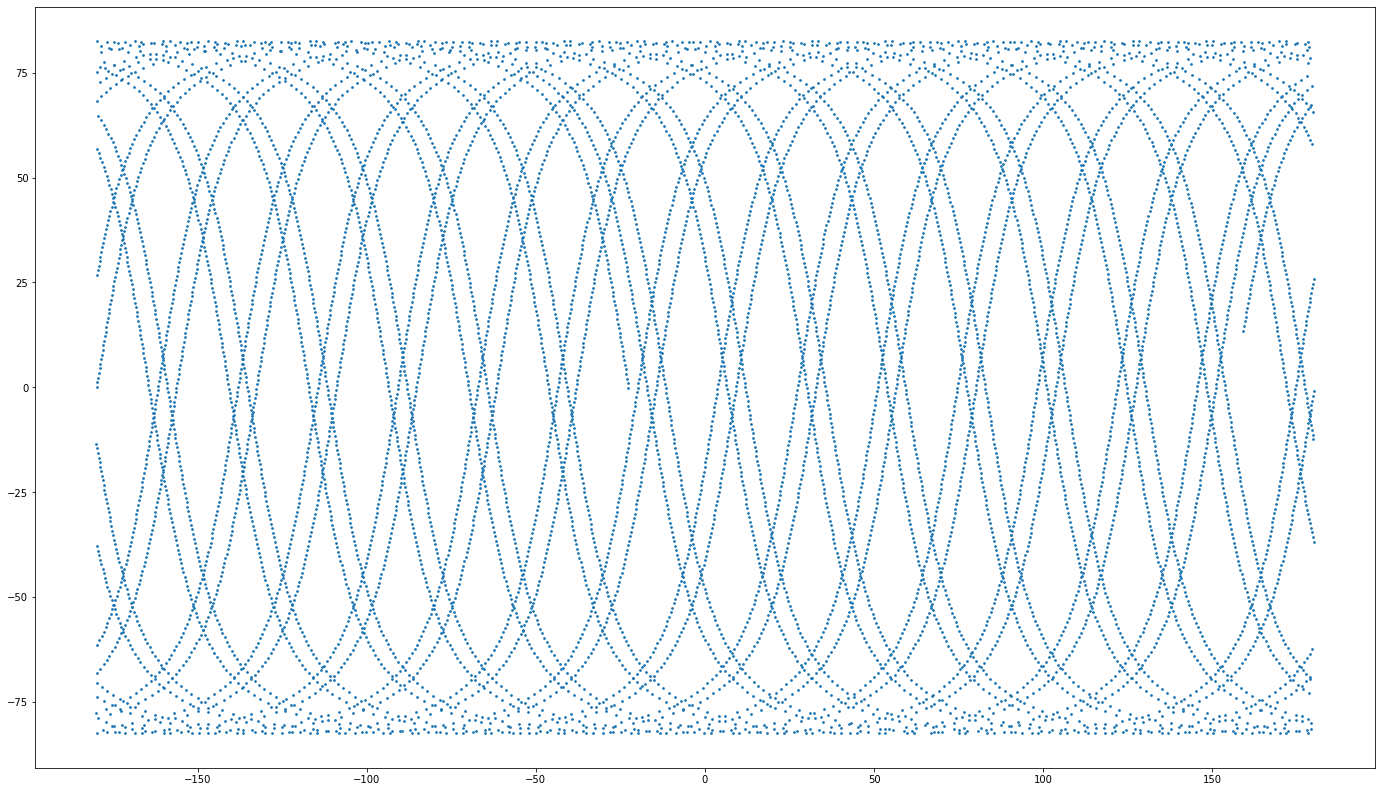

In [ ]:
#@markdown Afterward, we can plot the actual ground track.
plot_window = 100 #@param {type:"slider", min:0, max:100, step:1}
limit = int(len(itrs_coords) * plot_window/100) 

lon = itrs_coords.earth_location.geodetic.lon.degree[:limit]
lat = itrs_coords.earth_location.geodetic.lat.degree[:limit]

fig = plt.figure(figsize=(24,14))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(lon, lat, s = 3)

plt.show()

## Stage 5: Backtracking The Simulation

In the previous section, we were able to get a set of encounters using interpolation from a bunch of datapoints. Let's try to make things more precise, by stepping the propagator with more refined timesteps, at times closer to the actual encounters.

In this stage, we will also make everything a lot more precise, in terms of spacecraft orientation over the duration of the encounter, and whether it occurs in daylight or shade.


In [ ]:
intercept_points = Time(roots, format="mjd")

intercept_points.format = "iso"

times_of_flight = (intercept_points - orb.epoch).to(u.s)

propagated_positions = propagate(orb, times, method=cowell, ad=J2_perturbation, J2=Earth.J2.value, R=Earth.R.to(u.km).value)
propagated_velocities = propagated_positions.differentials["s"]

propagated_positions

<CartesianRepresentation (x, y, z) in km
    [(-4678.40860102, -5032.97424944,    0.        ),
     (-4690.2769989 , -5020.21852518,  130.92554015),
     (-4700.42219701, -5005.61838117,  261.80284416), ...,
     (-2490.84474761, -1608.50541841, 6230.63823994),
     (-2417.66182865, -1513.30675701, 6283.94277372),
     (-2343.6070042 , -1417.56233542, 6334.97475807)]
 (has differentials w.r.t.: 's')>